# 🔬 Introduction to Neural Networks in JAX and Flax

In this notebook, we will:

- Review key JAX concepts: random number handling, `jit`, `vmap`.
- Implement a simple fully-connected neural network (MLP) in **pure JAX**.
- Implement the same network in **Flax**.
- Compare both approaches and reflect on functional vs. object-oriented styles.

In [3]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import numpy as np
import matplotlib.pyplot as plt

## 🔁 JAX Basics: Randomness, `jit`, `vmap`

JAX handles randomness functionally: random keys are passed explicitly. Let's try a few basics.

In [4]:
seed = 1321
key = jax.random.key(seed)
subkey1, subkey2, key = jax.random.split(key,3)

print("Normal sample:", jax.random.normal(subkey1, (3,)))
print("Uniform sample:", jax.random.uniform(subkey2, (3,)))

Normal sample: [-0.20554379 -0.8826497  -0.60966676]
Uniform sample: [0.5871526  0.97001004 0.8939979 ]


`jit` compiles a function for performance. `vmap` vectorizes a function over batches.

In [5]:
def my_function(x):
    return x**2 + 1

x = jnp.arange(5.0)
print("Vectorized:", vmap(my_function)(x))
print("JIT compiled:", jit(my_function)(5.0))

Vectorized: [ 1.  2.  5. 10. 17.]
JIT compiled: 26.0


## A Simple Fully Connected Neural Network in JAX

Define an MLP with manual parameter management and forward pass.

Let us first recall what is a Multi-Layer-Perceptron andvisualize it!

In [6]:
import networkx as nx

def visualize_mlp(layer_sizes, ax=None):
    
    """
    Visualize a simple fully-connected feedforward neural network.
    
    Parameters:
    - layer_sizes: List of integers, number of neurons in each layer.
    - ax: Optional matplotlib Axes object.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    G = nx.DiGraph()
    pos = {}
    labels = {}
    
    v_spacing = 1.0
    h_spacing = 2.0
    
    node_idx = 0
    for layer_idx, num_neurons in enumerate(layer_sizes):
        for neuron_idx in range(num_neurons):
            node_name = f"L{layer_idx}N{neuron_idx}"
            pos[node_name] = (layer_idx * h_spacing, -neuron_idx * v_spacing + (num_neurons - 1) * v_spacing / 2)
            labels[node_name] = "●"
            G.add_node(node_name)
            if layer_idx > 0:
                for prev_idx in range(layer_sizes[layer_idx - 1]):
                    prev_name = f"L{layer_idx-1}N{prev_idx}"
                    G.add_edge(prev_name, node_name)
    
    nx.draw(G, pos, ax=ax, arrows=False, node_color="skyblue", node_size=1000, edge_color='gray')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)
    
    ax.set_title("MLP Architecture")
    ax.set_axis_off()
    plt.show()


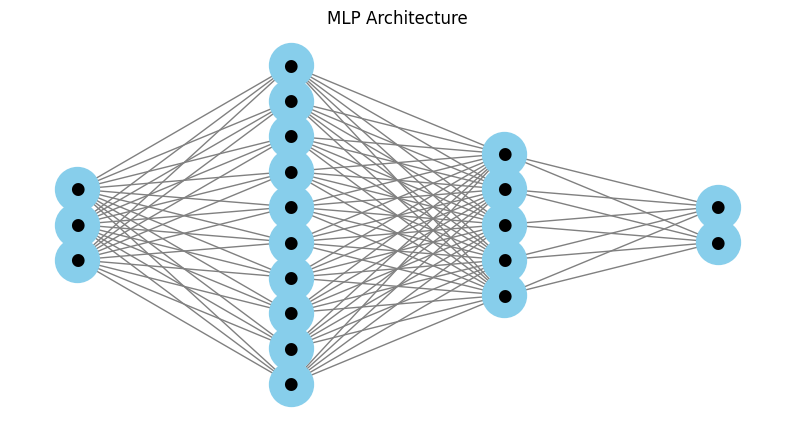

In [7]:
visualize_mlp([3, 10, 5, 2])

**Calculating the output of a neural network** -- The overall task is to calculate the activation values of the output layer of the network, to be handed back to the user. This calculation is done in a layer-by-layer fashion, which we explain now.

The "activation values" of the neurons in a layer form a vector $x$. To go from one layer to the next, one multiplies the "weight" matrix $w$ onto this vector and adds a bias vector $b$: 

$$
z_j = \sum_l w_{jl} x_l + b_j
$$

On top of that, one applies a nonlinear "activation function" $f$ to each entry in the resulting vector separately:

$$
x_j^{\rm new} = f(z_j)
$$

Using python and ```jax.numpy``` syntax, we can write these steps as:

```python
z = jnp.matmul( w, x ) + b
x = f( z )
```

Overall, this combination of a linear and a nonlinear operation results in a new vector, representing the activation values in the next layer. This process can be repeated for several layers (starting from the input), until one finally arrives at the output layer. The output activation vector is then returned to the user.

The network structure we define here is the default, and it is sometimes called a "fully connected" network or a "multilayer perceptron". Alternative structures exist that are taylored to specific purposes.

**Simple neural network** -- With everything we said so far, we could define the function ```NN``` that evaluates a neural network:

```python
def NN( x, weights, biases ):
    for w,b in zip(weights,biases):
        x = jnp.matmul( w, x ) + b
        x = f( x )
    return x 
```

```

Let us implement a simple MLP:

In [9]:
def NN(x, params):
    """
    Standard multilayer perception "MLP" with params['weights'] and params['biases'],
    applied to input vector x. Activation tanh applied to all
    layers except last.
    
    Returns activation vector of the output layer.
    """
    num_layers=len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'],params['biases'])):
        x = jnp.matmul(w,x) + b
        if layer_idx < num_layers - 1:  # Only apply the activation to hidden layers:
            x = jnp.tanh( x )
    return x

Let us create a function which generates a random parameter initialization

In [10]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params['weights'] = []
    params['biases'] = []
    
    for lower_layer, higher_layer in zip( num_neurons_layers[:-1], num_neurons_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey, [higher_layer,lower_layer] ) /  jnp.sqrt( lower_layer ) )
        
    for num_neurons in num_neurons_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

## Setting up a randomly initialized Network

In [38]:
key = jax.random.key( 11 )

# number of neurons in each hidden layer:
num_hidden_1 = 10 
num_hidden_2 = 5

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [1, num_hidden_1, num_hidden_2, 1] )

In [39]:
input = jnp.array([1.5])
output = NN(input , params )
print(output)

[-0.17682125]


## Batching our input to the network in Jax with vmap

In [40]:
NN_batch = vmap( NN, in_axes = [0,None], out_axes = 0) 
# we are telling that we want a batch dimension for the first argument (the vector x),
# and that this new batch dimension is the dimension 0
#The out_axes just indicates where the batch dimension is in the output, and we choose it also as 0.

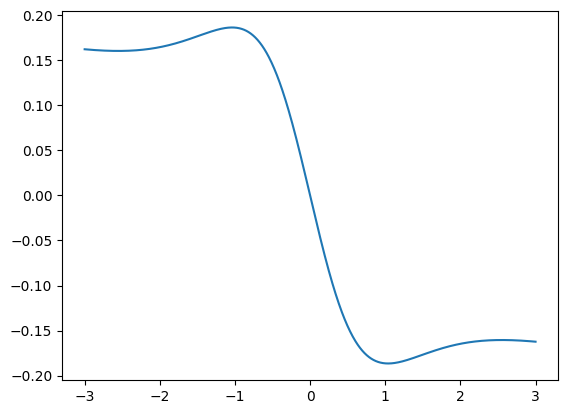

In [41]:
# Batching example:

# create a sweep in x, but convert the shape to [100,1]
# where 100 is the batchsize and '1' is the original input dimension
# required for the network:
batchsize = 1000
x = jnp.linspace( -3.0, +3.0, batchsize )[:,None]

plt.plot( x[:,0], NN_batch( x, params ) )
plt.show()

## Same Network Using Flax

In Flax, the network is an **object**, but it uses a functional interface to apply it.

```python
params = model.init(key, x)       # initializes parameters
model.apply(params, x)            # applies model
```

Note the `.apply(...)` syntax — it's a consequence of separating the function (`__call__`) from the parameters.
Flax Docs: https://flax-linen.readthedocs.io/en/latest/quick_start.html#

In [42]:
from flax import linen as nn

In [43]:
class Flax_NN(nn.Module):
  num_hidden_1: int
  output_neurons: int

  @nn.compact # decorator to define submodules (e.g. Dense, Conv) inline
  def __call__(self,x):
    # note: number of input neurons will be defined by the shape of x when calling the network for the first time!
    x = nn.Dense(features=self.num_hidden_1)(x) # neurons for  hidden layer
    x = nn.relu(x) # relu activation
    x = nn.Dense(features=self.output_neurons)(x) # neurons for output
    x = nn.tanh(x) # sigmoid activation
    return x

In [50]:
model = Flax_NN(num_hidden_1 = 5, output_neurons=1)
x = jnp.array([0.1])

# Parameter initialization:

key = jax.random.key(42)
params = model.init(key, x)
y = model.apply(params, x) 
print(y)

[0.1409269]


In [51]:
# Let us have a look at how params are stored:
params

{'params': {'Dense_0': {'kernel': Array([[-2.021197  , -1.9241767 , -2.1909916 ,  2.2488174 ,  0.16329753]],      dtype=float32),
   'bias': Array([0., 0., 0., 0., 0.], dtype=float32)},
  'Dense_1': {'kernel': Array([[ 0.24831605],
          [-0.31244385],
          [-0.01059145],
          [ 0.6081093 ],
          [ 0.31344348]], dtype=float32),
   'bias': Array([0.], dtype=float32)}}}

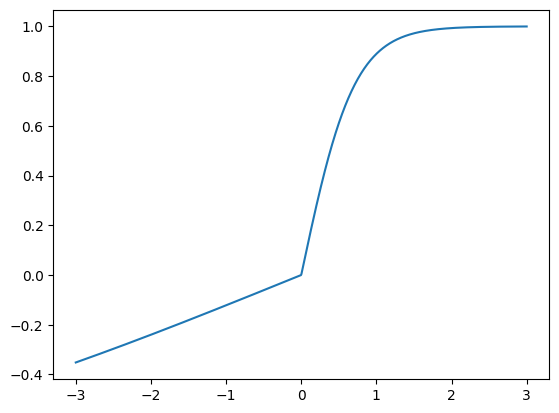

In [52]:
# Batching is even easier

input_batch = jnp.linspace(-3, 3, 1000)[:, None]  # shape (1000, 1)

output_batch = model.apply(params, input_batch) 
plt.plot(input_batch[:,0], output_batch  )
plt.show()

## ⚖️ Comparison: Flax vs JAX

| Feature                | JAX-only                           | Flax                                   |
|------------------------|------------------------------------|----------------------------------------|
| Param Init            | Manual                             | Automatic (`model.init`)               |
| Forward Pass          | `NN(x, params)`                    | `model.apply(params, x)`               |
| Style                 | Functional                         | Object-Oriented                        |
| Batch Handling        | via `vmap`                         | Automatic (`model.apply`)        |
| Parameter Format      | `dict of lists`                    | Nested dictionaries with names         |

👉 **Note:** In Flax, although we define a model class, we still apply it in a functional way. This is due to JAX’s functional nature and the need for explicit parameter management.